In [2]:
import pandas as pd
import numpy as np
import requests
%pip install Tiingo
from tiingo import TiingoClient
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression as lr
import statsmodels.api as sm
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.api import OLS
from scipy.stats import pearsonr, spearmanr, t, norm
from datetime import datetime
import seaborn as sns
from google.colab import drive
import re
import scipy
from scipy import stats
import math
from math import atanh, pow
from numpy import tanh
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
def make_time_series(df):
    for col in df.columns:
      if 'date' in col.lower():
        col_rename = 'date'
        df.rename(columns={col: col_rename}, inplace=True)
    datestring = '00:00:00+00:00'
    df['date'] = df['date'] + ' ' + datestring

    if df['date'].dtype == 'object':
      try:
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d %H:%M:%S%z')
      except ValueError:
        print('Converting "date" column to datetime format')
        df['date'] = pd.to_datetime(df['date'])
      df = df.set_index('date')
    return df

In [4]:
p_doll = pd.read_csv('gdrive/My Drive/US Dollar Index Historical Data.csv')
p_doll = p_doll[::-1]
c_doll = pd.read_csv('gdrive/My Drive/US Dollar Index Historical Data (1).csv')
c_doll = c_doll[::-1]
doll_df = pd.concat([p_doll, c_doll])
doll_df = make_time_series(doll_df)
doll_df['Close'] = doll_df['Price']
doll_df = doll_df.drop(columns=['Price', 'Change %', 'High', 'Low', 'Vol.'])
doll_df['Open'] = doll_df['Open'].apply(pd.to_numeric, downcast='float', errors='coerce')
doll_df['Close'] = doll_df['Close'].apply(pd.to_numeric, downcast='float', errors='coerce')
doll_df = doll_df.add_prefix('doll_')

Converting "date" column to datetime format


In [5]:
treasury_spread = pd.read_csv('gdrive/My Drive/DGS6MO.csv')
treasury_spread = make_time_series(treasury_spread)
treasury_spread['DGS6MO'] = treasury_spread['DGS6MO'].apply(pd.to_numeric, downcast='float', errors='coerce')
treasury_spread['DGS6MO'] = treasury_spread['DGS6MO'] / 100
treasury_spread.head(10)

,DGS6MO
date,
1981-09-01 00:00:00+00:00,0.1717
1981-09-02 00:00:00+00:00,0.1732
1981-09-03 00:00:00+00:00,0.1742
1981-09-04 00:00:00+00:00,0.1737
1981-09-07 00:00:00+00:00,NaN
1981-09-08 00:00:00+00:00,0.1743
1981-09-09 00:00:00+00:00,0.1708
1981-09-10 00:00:00+00:00,0.1687
1981-09-11 00:00:00+00:00,0.1633


In [6]:
doll_spread = pd.merge(doll_df, treasury_spread, left_index=True, right_index=True)
doll_spread = doll_spread.resample('M').last()
doll_spread = doll_spread.ffill(axis=0)
doll_spread

,doll_Open,doll_Close,DGS6MO
date,,,
1990-12-31 00:00:00+00:00,83.37,83.07,0.0673
1991-01-31 00:00:00+00:00,82.24,82.00,0.0649
1991-02-28 00:00:00+00:00,83.80,84.08,0.0632
1991-03-31 00:00:00+00:00,92.35,92.02,0.0605
1991-04-30 00:00:00+00:00,92.60,91.54,0.0583
...,...,...,...
2023-11-30 00:00:00+00:00,102.83,103.50,0.0538
2023-12-31 00:00:00+00:00,101.20,101.33,0.0526
2024-01-31 00:00:00+00:00,103.42,103.27,0.0518


In [8]:
#Install the client
config = {}

config['session'] = True
config['api_key'] = ""
client = TiingoClient(config)

In [9]:
brkb_etf = client.get_dataframe('BRK-B',startDate='1996-05-10', endDate='2024-02-01', frequency='daily')
spy_etf = client.get_dataframe('SPY',startDate='1996-05-10', endDate='2024-02-01', frequency='daily')
brkb_etf = brkb_etf.add_prefix('brkb_')
spy_etf = spy_etf.add_prefix('spy_')
brkb_etf

,brkb_close,brkb_high,brkb_low,brkb_open,brkb_volume,brkb_adjClose,brkb_adjHigh,brkb_adjLow,brkb_adjOpen,brkb_adjVolume,brkb_divCash,brkb_splitFactor
date,,,,,,,,,,,,
1996-05-10 00:00:00+00:00,1200.00,1210.00,1180.000,1200.00,21200,24.00,24.20,23.600,24.00,1060000,0.0,1.0
1996-05-13 00:00:00+00:00,1195.00,1205.00,1165.000,1200.00,14000,23.90,24.10,23.300,24.00,700000,0.0,1.0
1996-05-14 00:00:00+00:00,1180.00,1205.00,1155.000,1200.00,6200,23.60,24.10,23.100,24.00,310000,0.0,1.0
1996-05-15 00:00:00+00:00,1160.00,1185.00,1150.000,1180.00,10900,23.20,23.70,23.000,23.60,545000,0.0,1.0
1996-05-16 00:00:00+00:00,1130.00,1155.00,1115.000,1155.00,7200,22.60,23.10,22.300,23.10,360000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-26 00:00:00+00:00,385.40,385.73,380.000,381.05,3624361,385.40,385.73,380.000,381.05,3624361,0.0,1.0
2024-01-29 00:00:00+00:00,383.18,385.70,379.170,385.49,3799251,383.18,385.70,379.170,385.49,3799251,0.0,1.0
2024-01-30 00:00:00+00:00,387.15,387.64,380.080,383.24,3094226,387.15,387.64,380.080,383.24,3094226,0.0,1.0


In [10]:
spy_brkb_pair = pd.concat([spy_etf, brkb_etf], axis=1)
spy_brkb_pair

,spy_close,spy_high,spy_low,spy_open,spy_volume,spy_adjClose,spy_adjHigh,spy_adjLow,spy_adjOpen,spy_adjVolume,...,brkb_low,brkb_open,brkb_volume,brkb_adjClose,brkb_adjHigh,brkb_adjLow,brkb_adjOpen,brkb_adjVolume,brkb_divCash,brkb_splitFactor
date,,,,,,,,,,,,,,,,,,,,,
1996-05-10 00:00:00+00:00,65.375000,65.593697,65.062500,65.375000,925100,39.797721,39.930855,39.607484,39.797721,925100,...,1180.000,1200.00,21200,24.00,24.20,23.600,24.00,1060000,0.0,1.0
1996-05-13 00:00:00+00:00,66.359299,66.640602,65.468697,65.531197,867500,40.396924,40.568170,39.854760,39.892808,867500,...,1165.000,1200.00,14000,23.90,24.10,23.300,24.00,700000,0.0,1.0
1996-05-14 00:00:00+00:00,66.765602,66.937500,66.562500,66.625000,632300,40.644265,40.748910,40.520624,40.558672,632300,...,1155.000,1200.00,6200,23.60,24.10,23.100,24.00,310000,0.0,1.0
1996-05-15 00:00:00+00:00,66.687500,67.312500,66.640602,66.781197,466100,40.596720,40.977195,40.568170,40.653759,466100,...,1150.000,1180.00,10900,23.20,23.70,23.000,23.60,545000,0.0,1.0
1996-05-16 00:00:00+00:00,66.828102,66.937500,66.281197,66.312500,514400,40.682312,40.748910,40.349378,40.368434,514400,...,1115.000,1155.00,7200,22.60,23.10,22.300,23.10,360000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-26 00:00:00+00:00,487.410000,489.120000,486.540000,487.590000,76641609,485.889956,487.594623,485.022670,486.069395,76641609,...,380.000,381.05,3624361,385.40,385.73,380.000,381.05,3624361,0.0,1.0
2024-01-29 00:00:00+00:00,491.270000,491.415000,487.170000,487.730000,61322751,489.737918,489.882466,485.650705,486.208958,61322751,...,379.170,385.49,3799251,383.18,385.70,379.170,385.49,3799251,0.0,1.0
2024-01-30 00:00:00+00:00,490.890000,491.620000,490.110000,490.560000,58618386,489.359104,490.086827,488.581536,489.030133,58618386,...,380.080,383.24,3094226,387.15,387.64,380.080,383.24,3094226,0.0,1.0


In [11]:
spy_brkb_pair = spy_brkb_pair.resample('M').last()
spy_brkb_pair

,spy_close,spy_high,spy_low,spy_open,spy_volume,spy_adjClose,spy_adjHigh,spy_adjLow,spy_adjOpen,spy_adjVolume,...,brkb_low,brkb_open,brkb_volume,brkb_adjClose,brkb_adjHigh,brkb_adjLow,brkb_adjOpen,brkb_adjVolume,brkb_divCash,brkb_splitFactor
date,,,,,,,,,,,,,,,,,,,,,
1996-05-31 00:00:00+00:00,66.875000,67.640602,66.875000,67.359299,923500,40.710862,41.176930,40.710862,41.005684,923500,...,990.000,1010.00,4600,20.40,20.40,19.800,20.20,230000,0.0,1.0
1996-06-30 00:00:00+00:00,67.109299,67.500000,66.968697,67.156197,1060800,41.068082,41.307174,40.982039,41.096781,1060800,...,1005.000,1005.00,2100,20.66,20.66,20.100,20.10,105000,0.0,1.0
1996-07-31 00:00:00+00:00,64.093697,64.265602,63.515598,63.671799,767100,39.222659,39.327858,38.868887,38.964475,767100,...,1020.000,1027.00,500,20.52,20.54,20.400,20.54,25000,0.0,1.0
1996-08-31 00:00:00+00:00,65.328102,66.015602,65.125000,66.000000,1500900,39.978064,40.398785,39.853774,40.389237,1500900,...,1034.000,1038.00,700,20.82,20.88,20.680,20.76,35000,0.0,1.0
1996-09-30 00:00:00+00:00,68.625000,69.062500,68.578102,68.781197,578200,42.210951,42.480055,42.182104,42.307027,578200,...,1064.000,1064.00,1100,21.46,21.60,21.280,21.28,55000,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 00:00:00+00:00,418.200000,418.530000,414.210000,416.180000,79665150,415.209520,415.537160,411.248052,413.203965,79665150,...,337.500,337.95,3067894,341.33,341.49,337.500,337.95,3067894,0.0,1.0
2023-11-30 00:00:00+00:00,456.400000,456.760000,453.340000,455.480000,79752700,453.136358,453.493784,450.098240,452.222937,79752700,...,358.420,359.45,4607404,360.00,360.43,358.420,359.45,4607404,0.0,1.0
2023-12-31 00:00:00+00:00,475.310000,477.030000,473.300000,476.490000,122283149,473.827692,475.542328,471.823960,475.004012,122283149,...,355.310,357.56,3270014,356.66,357.86,355.310,357.56,3270014,0.0,1.0


In [12]:
def drop_cols(df, str1, str2):
    df = df.drop(columns=[str1+'_close', str1+'_high', str1+'_low', str1+'_open', str1+'_adjHigh', str1+'_adjLow',
                        str1+'_volume', str1+'_divCash', str1+'_splitFactor', str1+'_adjVolume',
                        str2+'_close', str2+'_high', str2+'_low', str2+'_open', str2+'_adjHigh', str2+'_adjLow',
                        str2+'_volume', str2+'_divCash', str2+'_splitFactor', str2+'_adjVolume'])
    return df
spy_brkb_pair = drop_cols(spy_brkb_pair, 'spy', 'brkb')
spy_brkb_pair

,spy_adjClose,spy_adjOpen,brkb_adjClose,brkb_adjOpen
date,,,,
1996-05-31 00:00:00+00:00,40.710862,41.005684,20.40,20.20
1996-06-30 00:00:00+00:00,41.068082,41.096781,20.66,20.10
1996-07-31 00:00:00+00:00,39.222659,38.964475,20.52,20.54
1996-08-31 00:00:00+00:00,39.978064,40.389237,20.82,20.76
1996-09-30 00:00:00+00:00,42.210951,42.307027,21.46,21.28
...,...,...,...,...
2023-10-31 00:00:00+00:00,415.209520,413.203965,341.33,337.95
2023-11-30 00:00:00+00:00,453.136358,452.222937,360.00,359.45
2023-12-31 00:00:00+00:00,473.827692,475.004012,356.66,357.56


In [13]:
df = pd.merge(spy_brkb_pair, doll_spread, how='left',left_index=True, right_index=True)
df['spy_6m_ret'] = df['spy_adjClose'].pct_change(6)
df['doll_ret_6m'] = df['doll_Close'].pct_change(6)
df['rf_rt_trail_6m'] = df['DGS6MO'].shift(6)
df['eq_risk_prem_trail_6m'] = df['spy_6m_ret'] - df['rf_rt_trail_6m']
spy_brkb_pair.head(10)

,spy_adjClose,spy_adjOpen,brkb_adjClose,brkb_adjOpen
date,,,,
1996-05-31 00:00:00+00:00,40.710862,41.005684,20.40,20.20
1996-06-30 00:00:00+00:00,41.068082,41.096781,20.66,20.10
1996-07-31 00:00:00+00:00,39.222659,38.964475,20.52,20.54
1996-08-31 00:00:00+00:00,39.978064,40.389237,20.82,20.76
1996-09-30 00:00:00+00:00,42.210951,42.307027,21.46,21.28
1996-10-31 00:00:00+00:00,43.575662,43.220078,21.58,21.56
1996-11-30 00:00:00+00:00,46.756879,46.747282,22.06,22.00
1996-12-31 00:00:00+00:00,45.667833,46.556840,22.24,22.36
1997-01-31 00:00:00+00:00,48.489462,48.818040,23.10,23.10


In [14]:
df['rf_rt_chng'] = df['DGS6MO'].diff()
df['rf_rt_chg_6m_trail'] = df['rf_rt_chng'].diff(6)
df['brkb_ret_6m'] = df['brkb_adjClose'].pct_change(6)

df.dropna(inplace=True)
df

,spy_adjClose,spy_adjOpen,brkb_adjClose,brkb_adjOpen,doll_Open,doll_Close,DGS6MO,spy_6m_ret,doll_ret_6m,rf_rt_trail_6m,eq_risk_prem_trail_6m,rf_rt_chng,rf_rt_chg_6m_trail,brkb_ret_6m
date,,,,,,,,,,,,,,
1996-12-31 00:00:00+00:00,45.667833,46.556840,22.24,22.36,88.85,88.18,0.0533,0.112003,0.004099,0.0537,0.058303,0.0008,0.0007,0.076476
1997-01-31 00:00:00+00:00,48.489462,48.818040,23.10,23.10,92.98,93.04,0.0528,0.236261,0.083120,0.0547,0.181561,-0.0005,-0.0015,0.125731
1997-02-28 00:00:00+00:00,48.953291,49.011303,23.76,23.72,94.85,94.89,0.0539,0.224504,0.098773,0.0549,0.169604,0.0011,0.0009,0.141210
1997-03-31 00:00:00+00:00,46.792698,47.743263,24.20,24.90,94.73,94.72,0.0555,0.108544,0.077098,0.0537,0.054844,0.0016,0.0028,0.127679
1997-04-30 00:00:00+00:00,49.722059,49.198293,25.42,25.46,97.00,97.18,0.0553,0.141051,0.111518,0.0530,0.088051,-0.0002,0.0005,0.177943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-10-31 00:00:00+00:00,415.209520,413.203965,341.33,337.95,106.16,106.66,0.0554,0.012810,0.049184,0.0506,-0.037790,0.0001,-0.0011,0.038898
2023-11-30 00:00:00+00:00,453.136358,452.222937,360.00,359.45,102.83,103.50,0.0538,0.100245,-0.007956,0.0546,0.045645,-0.0016,-0.0056,0.121216
2023-12-31 00:00:00+00:00,473.827692,475.004012,356.66,357.56,101.20,101.33,0.0526,0.080456,-0.015353,0.0547,0.025756,-0.0012,-0.0013,0.045924


In [15]:
def make_ols(df,x_col, y_col):
  X = sm.add_constant(df[x_col])
  model = sm.OLS(df[y_col], X).fit()
  print(f'Depend variable is {y_col} and ind variable is {x_col} and adjusted r^2 is {model.rsquared_adj:.3f}')
y_var = 'brkb_ret_6m'
columns = ['DGS6MO', 'doll_ret_6m', 'rf_rt_trail_6m', 'eq_risk_prem_trail_6m','rf_rt_chng',	'rf_rt_chg_6m_trail']
for col in columns:
  make_ols(df, col, y_var)

Depend variable is brkb_ret_6m and ind variable is DGS6MO and adjusted r^2 is 0.006
Depend variable is brkb_ret_6m and ind variable is doll_ret_6m and adjusted r^2 is 0.006
Depend variable is brkb_ret_6m and ind variable is rf_rt_trail_6m and adjusted r^2 is 0.009
Depend variable is brkb_ret_6m and ind variable is eq_risk_prem_trail_6m and adjusted r^2 is 0.254
Depend variable is brkb_ret_6m and ind variable is rf_rt_chng and adjusted r^2 is 0.009
Depend variable is brkb_ret_6m and ind variable is rf_rt_chg_6m_trail and adjusted r^2 is 0.009


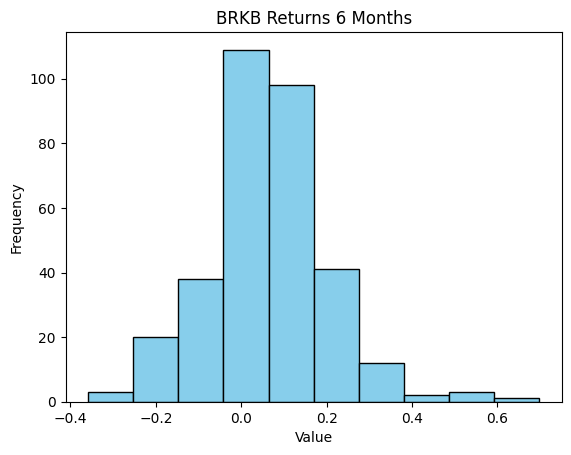

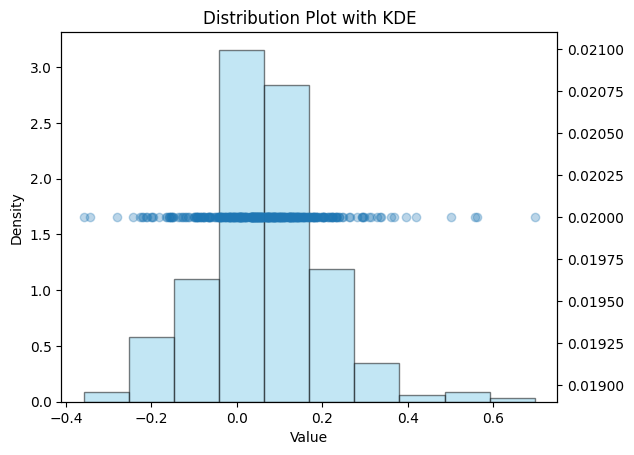

In [16]:
# Histogram
plt.hist(df['brkb_ret_6m'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('BRKB Returns 6 Months')
plt.show()

# Kernel Density Estimation (KDE) plot
plt.figure()
plt.hist(df['brkb_ret_6m'], bins=10, color='skyblue', edgecolor='black', density=True, alpha=0.5)  # Histogram for reference
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Distribution Plot with KDE')
plt.twinx()  # Create a twin Axes sharing the xaxis
plt.plot(df['brkb_ret_6m'], [0.02] * len(df['brkb_ret_6m']), 'o', alpha=0.3)  # Points for reference
plt.show()

In [17]:
split = len(df) // 2
df_past = df[:split+6]
df_past.tail()

,spy_adjClose,spy_adjOpen,brkb_adjClose,brkb_adjOpen,doll_Open,doll_Close,DGS6MO,spy_6m_ret,doll_ret_6m,rf_rt_trail_6m,eq_risk_prem_trail_6m,rf_rt_chng,rf_rt_chg_6m_trail,brkb_ret_6m
date,,,,,,,,,,,,,,
2010-08-31 00:00:00+00:00,81.363450,81.062132,78.78,77.81,83.17,83.20,0.0019,-0.040554,0.035341,0.0019,-0.042454,-0.0001,-0.0005,-0.016848
2010-09-30 00:00:00+00:00,88.649854,89.364459,82.68,82.83,78.79,78.72,0.0019,-0.014645,-0.028987,0.0024,-0.017045,0.0000,-0.0005,0.017350
2010-10-31 00:00:00+00:00,92.036460,91.873344,79.56,80.04,77.27,77.27,0.0017,0.007413,-0.056187,0.0025,0.004913,-0.0002,-0.0003,0.033247
2010-11-30 00:00:00+00:00,92.036460,91.640320,79.68,79.06,80.84,81.19,0.0021,0.094365,-0.062363,0.0022,0.092165,0.0004,0.0007,0.129412
2010-12-31 00:00:00+00:00,98.188568,98.016787,80.11,79.27,79.46,79.03,0.0019,0.231225,-0.081260,0.0022,0.229025,-0.0002,-0.0002,0.005270


In [18]:
df_curr = df[split+6:]
df_curr.head()

,spy_adjClose,spy_adjOpen,brkb_adjClose,brkb_adjOpen,doll_Open,doll_Close,DGS6MO,spy_6m_ret,doll_ret_6m,rf_rt_trail_6m,eq_risk_prem_trail_6m,rf_rt_chng,rf_rt_chg_6m_trail,brkb_ret_6m
date,,,,,,,,,,,,,,
2011-01-31 00:00:00+00:00,100.476381,100.000079,81.75,81.93,78.11,77.73,0.0017,0.179361,-0.046726,0.0020,0.177361,-0.0002,-1.164153e-10,0.046467
2011-02-28 00:00:00+00:00,103.966663,103.708991,87.28,86.46,77.22,76.89,0.0018,0.277805,-0.075841,0.0019,0.275905,0.0001,2.000001e-04,0.107895
2011-03-31 00:00:00+00:00,103.977780,103.985622,83.63,83.94,76.14,75.86,0.0017,0.172904,-0.036331,0.0019,0.171004,-0.0001,-1.000001e-04,0.011490
2011-04-30 00:00:00+00:00,106.989129,106.777393,83.30,83.20,73.06,72.93,0.0011,0.162465,-0.056167,0.0017,0.160765,-0.0006,-4.000000e-04,0.047009
2011-05-31 00:00:00+00:00,105.789295,105.687348,79.07,78.43,74.73,74.64,0.0012,0.149428,-0.080675,0.0021,0.147328,0.0001,-3.000000e-04,-0.007656


In [19]:
for col in columns:
  make_ols(df_past, col, y_var)

Depend variable is brkb_ret_6m and ind variable is DGS6MO and adjusted r^2 is 0.034
Depend variable is brkb_ret_6m and ind variable is doll_ret_6m and adjusted r^2 is -0.001
Depend variable is brkb_ret_6m and ind variable is rf_rt_trail_6m and adjusted r^2 is 0.047
Depend variable is brkb_ret_6m and ind variable is eq_risk_prem_trail_6m and adjusted r^2 is 0.207
Depend variable is brkb_ret_6m and ind variable is rf_rt_chng and adjusted r^2 is 0.015
Depend variable is brkb_ret_6m and ind variable is rf_rt_chg_6m_trail and adjusted r^2 is 0.019


In [20]:
for col in columns:
  make_ols(df_curr, col, y_var)

Depend variable is brkb_ret_6m and ind variable is DGS6MO and adjusted r^2 is -0.003
Depend variable is brkb_ret_6m and ind variable is doll_ret_6m and adjusted r^2 is 0.019
Depend variable is brkb_ret_6m and ind variable is rf_rt_trail_6m and adjusted r^2 is -0.002
Depend variable is brkb_ret_6m and ind variable is eq_risk_prem_trail_6m and adjusted r^2 is 0.443
Depend variable is brkb_ret_6m and ind variable is rf_rt_chng and adjusted r^2 is -0.005
Depend variable is brkb_ret_6m and ind variable is rf_rt_chg_6m_trail and adjusted r^2 is -0.006


In [21]:
def test_normality(data, alpha=0.05):

    statistic, p_value = scipy.stats.shapiro(data)

    if p_value > alpha:
        result = "Data is normally distributed"
    else:
        result = "Data is not normally distributed"

    return result
print(test_normality(df_past['brkb_ret_6m']))
print(test_normality(df_curr['brkb_ret_6m']))

Data is not normally distributed
Data is normally distributed


In [22]:
print(len(df_past))
print(len(df_curr))

169
158


#Compare Distributions of Data

In [23]:
stats.ks_2samp(df_past[y_var], df_curr[y_var])

KstestResult(statistic=0.14482061268818816, pvalue=0.05699675493691397, statistic_location=0.05460750853242313, statistic_sign=1)

#Looking at Heteroskedasticy

In [24]:
def breush_pagan(df,x_col, y_col):
  X = sm.add_constant(df[x_col])
  model = sm.OLS(df[y_col], X).fit()
  bp_test_statistic, bp_p_value, _, _ = het_breuschpagan(model.resid, X)
  print("Breusch-Pagan test statistic:", bp_test_statistic)
  print("P-value:", bp_p_value)

breush_pagan(df_past, 'eq_risk_prem_trail_6m', y_var)
breush_pagan(df_curr, 'eq_risk_prem_trail_6m', y_var)

Breusch-Pagan test statistic: 0.1553396241727797
P-value: 0.6934839698799833
Breusch-Pagan test statistic: 0.19298886491343814
P-value: 0.6604405666745172


In [25]:
from statsmodels.nonparametric.smoothers_lowess import lowess
def scatter_plot(df, date,x_col, y_col, title=None, xlabel=None, ylabel=None):
  plt.figure(figsize=(8, 6))
  plt.scatter(df[x_col], df[y_col], alpha=0.5)
  plt.title(title if title else f'{date} Scatter Plot of {x_col} vs {y_col}')
  plt.xlabel(xlabel if xlabel else x_col)
  plt.ylabel(ylabel if ylabel else y_col)
  plt.grid(True)
  plt.show()

Equtiy Risk Premium

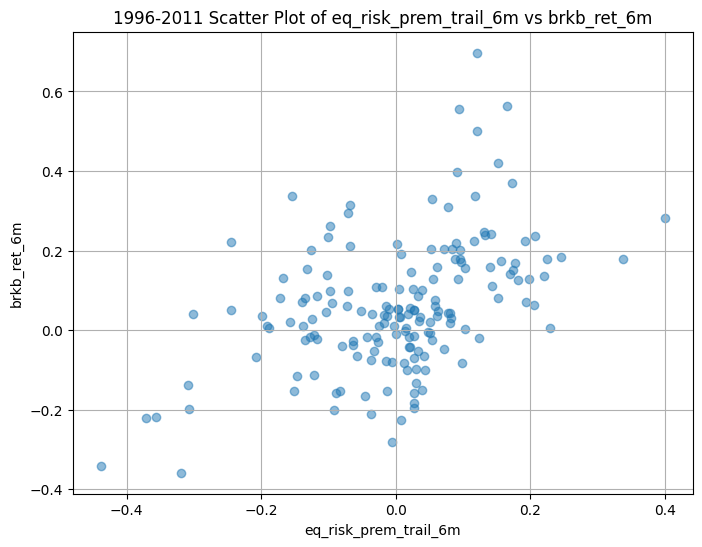

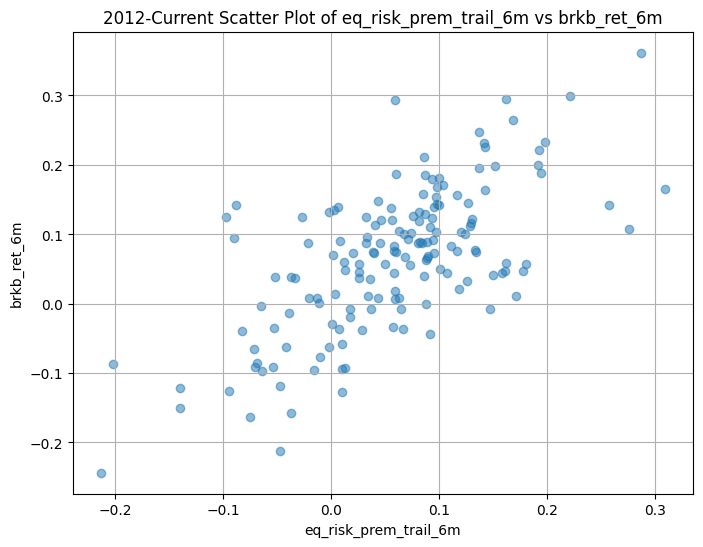

In [26]:
scatter_plot(df_past,'1996-2011', 'eq_risk_prem_trail_6m', 'brkb_ret_6m', None,  'eq_risk_prem_trail_6m', 'brkb_ret_6m')

scatter_plot(df_curr,'2012-Current', 'eq_risk_prem_trail_6m', 'brkb_ret_6m', None,  'eq_risk_prem_trail_6m', 'brkb_ret_6m')

Looking at the risk free rate

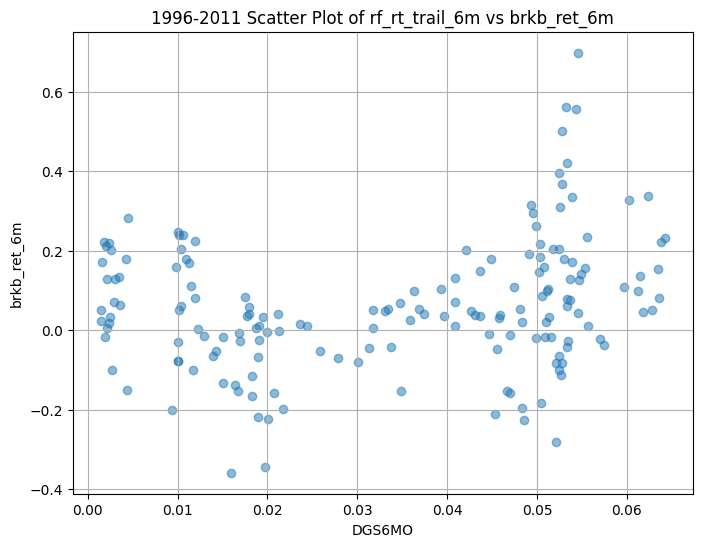

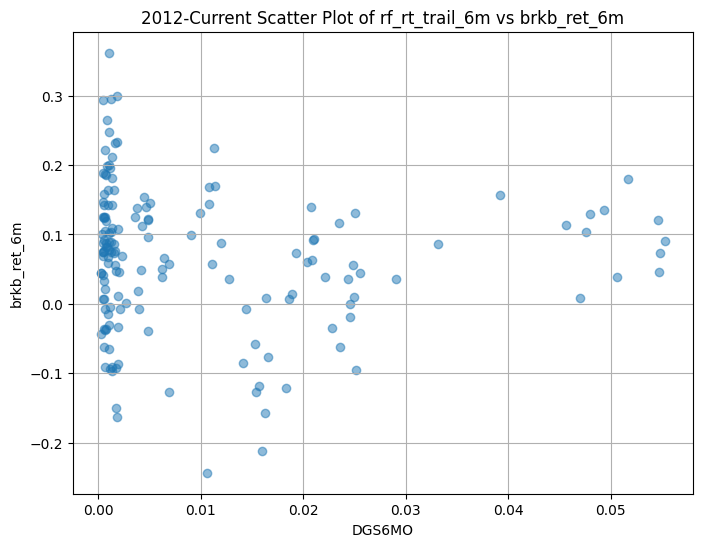

In [27]:
scatter_plot(df_past, '1996-2011','rf_rt_trail_6m', 'brkb_ret_6m', None,  'DGS6MO', 'brkb_ret_6m')

scatter_plot(df_curr, '2012-Current', 'rf_rt_trail_6m', 'brkb_ret_6m', None,  'DGS6MO', 'brkb_ret_6m')

In [28]:
breush_pagan(df_curr, 'eq_risk_prem_trail_6m', y_var)
breush_pagan(df_past, 'eq_risk_prem_trail_6m', y_var)

Breusch-Pagan test statistic: 0.19298886491343814
P-value: 0.6604405666745172
Breusch-Pagan test statistic: 0.1553396241727797
P-value: 0.6934839698799833


In [29]:
breush_pagan(df_curr, 'rf_rt_trail_6m', y_var)
breush_pagan(df_past, 'rf_rt_trail_6m', y_var)

Breusch-Pagan test statistic: 1.585906149229242
P-value: 0.2079120073452106
Breusch-Pagan test statistic: 2.123596714379193
P-value: 0.14504556998518783


#Generating Basic Summary Statistics

In [30]:
def make_summary(df,x_col, y_col):
  X = sm.add_constant(df[x_col])
  model = sm.OLS(df[y_col], X).fit()
  print(model.summary())
make_summary(df_past, 'eq_risk_prem_trail_6m', y_var)
make_summary(df_curr, 'eq_risk_prem_trail_6m', y_var)

                            OLS Regression Results                            
Dep. Variable:            brkb_ret_6m   R-squared:                       0.212
Model:                            OLS   Adj. R-squared:                  0.207
Method:                 Least Squares   F-statistic:                     44.92
Date:                Sat, 27 Apr 2024   Prob (F-statistic):           3.01e-10
Time:                        19:55:08   Log-Likelihood:                 86.090
No. Observations:                 169   AIC:                            -168.2
Df Residuals:                     167   BIC:                            -161.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.05

In [31]:
make_summary(df_past, 'rf_rt_trail_6m', y_var)
make_summary(df_curr, 'rf_rt_trail_6m', y_var)

                            OLS Regression Results                            
Dep. Variable:            brkb_ret_6m   R-squared:                       0.052
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     9.236
Date:                Sat, 27 Apr 2024   Prob (F-statistic):            0.00275
Time:                        19:55:08   Log-Likelihood:                 70.509
No. Observations:                 169   AIC:                            -137.0
Df Residuals:                     167   BIC:                            -130.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0031      0.024     -0.

#Looking at correlation coefficients

In [32]:
#Calculate Spearman correlation coefficient for non linear data
eprem_past_corr, eprem_past_pval = spearmanr(df_past['brkb_ret_6m'], df_past['eq_risk_prem_trail_6m'])
eprem_curr_corr, eprem_curr_pval = spearmanr(df_curr['brkb_ret_6m'], df_curr['eq_risk_prem_trail_6m'])

print('Spearman correlation coefficient between columns brkb_ret_6m and eq_risk_prem_trail_6m:', round(eprem_past_corr,3))
print("P-value for brkb_ret_6m and eq_risk_prem_trail_6m:", round(eprem_past_pval, 3))

print('Spearman correlation coefficient between columns brkb_ret_6m and eq_risk_prem_trail_6m:', round(eprem_curr_corr, 3))
print("P-value for brkb_ret_6m and eq_risk_prem_trail_6m:", round(eprem_curr_pval, 5))

Spearman correlation coefficient between columns brkb_ret_6m and eq_risk_prem_trail_6m: 0.436
P-value for brkb_ret_6m and eq_risk_prem_trail_6m: 0.0
Spearman correlation coefficient between columns brkb_ret_6m and eq_risk_prem_trail_6m: 0.608
P-value for brkb_ret_6m and eq_risk_prem_trail_6m: 0.0


In [33]:
rf_past_corr, rf_past_pval = spearmanr(df_past['brkb_ret_6m'], df_past['rf_rt_trail_6m'])
rf_curr_corr, rf_curr_pval = spearmanr(df_curr['brkb_ret_6m'], df_curr['rf_rt_trail_6m'])

print('Spearman correlation coefficient between columns brkb_ret_6m and rf_rt_trail_6m:', round(rf_past_corr,3))
print("P-value for brkb_ret_6m and eq_risk_prem_trail_6m:", round(rf_past_pval, 3))

print('Spearman correlation coefficient between columns brkb_ret_6m and rf_rt_trail_6m:', round(rf_curr_corr, 3))
print("P-value for brkb_ret_6m and eq_risk_prem_trail_6m:", round(rf_curr_pval, 3))

Spearman correlation coefficient between columns brkb_ret_6m and rf_rt_trail_6m: 0.207
P-value for brkb_ret_6m and eq_risk_prem_trail_6m: 0.007
Spearman correlation coefficient between columns brkb_ret_6m and rf_rt_trail_6m: -0.15
P-value for brkb_ret_6m and eq_risk_prem_trail_6m: 0.06


#Running Chowtest

In [34]:
def linear_residuals(X, y):

    # fits the linear model
    model = lr().fit(X, y)

    # creates a dataframe with the predicted y in a column called y_hat
    summary_result = pd.DataFrame(columns = ['y_hat'])
    yhat_list = [float(i[0]) for i in np.ndarray.tolist(model.predict(X))]
    summary_result['y_hat'] = yhat_list
    # saves the actual y values in the y_actual column
    summary_result['y_actual'] = y.values
    # calculates the residuals
    summary_result['residuals'] = summary_result.y_actual - summary_result.y_hat
    # squares the residuals
    summary_result['residuals_sq'] = summary_result.residuals ** 2

    return(summary_result)



# defines a function to return the sum of squares of a linear regression, where X is a
# pandas dataframe of the independent variables and y is a pandas dataframe of the dependent
# variable
def calculate_RSS(X, y):

    # calls the linear_residual function
    resid_data = linear_residuals(X, y)
    # calculates the sum of squared resiudals
    rss = resid_data.residuals_sq.sum()

    # returns the sum of squared residuals
    return(rss)



# defines a function to return the p-value from a Chow Test
def ChowTest(X, y, last_index_in_model_1, first_index_in_model_2):

    # gets the RSS for the entire period
    rss_pooled = calculate_RSS(X, y)

    # splits the X and y dataframes and gets the rows from the first row in the dataframe
    # to the last row in the model 1 testing period and then calculates the RSS
    X1 = X.loc[:last_index_in_model_1]
    y1 = y.loc[:last_index_in_model_1]
    rss1 = calculate_RSS(X1, y1)

    # splits the X and y dataframes and gets the rows from the first row in the model 2
    # testing period to the last row in the dataframe and then calculates the RSS
    X2 = X.loc[first_index_in_model_2:]
    y2 = y.loc[first_index_in_model_2:]
    rss2 = calculate_RSS(X2, y2)

    # gets the number of independent variables, plus 1 for the constant in the regression
    k = X.shape[1] + 1
    # gets the number of observations in the first period
    N1 = X1.shape[0]
    # gets the number of observations in the second period
    N2 = X2.shape[0]

    # calculates the numerator of the Chow Statistic
    numerator = (rss_pooled - (rss1 + rss2)) / k
    # calculates the denominator of the Chow Statistic
    denominator = (rss1 + rss2) / (N1 + N2 - 2 * k)

    # calculates the Chow Statistic
    Chow_Stat = numerator / denominator

    # Chow statistics are distributed in a F-distribution with k and N1 + N2 - 2k degrees of
    # freedom
    from scipy.stats import f

    # calculates the p-value by subtracting 1 by the cumulative probability at the Chow
    # statistic from an F-distribution with k and N1 + N2 - 2k degrees of freedom
    p_value = 1 - f.cdf(Chow_Stat, dfn = 5, dfd = (N1 + N2 - 2 * k))

    # saves the Chow_State and p_value in a tuple
    result = (Chow_Stat, p_value)

    # returns the p-value
    return(result)

In [35]:
df_copy = df.copy()
df_copy['index'] = range(len(df_copy))
df_copy = df_copy.set_index(['index'])
df_copy

,spy_adjClose,spy_adjOpen,brkb_adjClose,brkb_adjOpen,doll_Open,doll_Close,DGS6MO,spy_6m_ret,doll_ret_6m,rf_rt_trail_6m,eq_risk_prem_trail_6m,rf_rt_chng,rf_rt_chg_6m_trail,brkb_ret_6m
index,,,,,,,,,,,,,,
0,45.667833,46.556840,22.24,22.36,88.85,88.18,0.0533,0.112003,0.004099,0.0537,0.058303,0.0008,0.0007,0.076476
1,48.489462,48.818040,23.10,23.10,92.98,93.04,0.0528,0.236261,0.083120,0.0547,0.181561,-0.0005,-0.0015,0.125731
2,48.953291,49.011303,23.76,23.72,94.85,94.89,0.0539,0.224504,0.098773,0.0549,0.169604,0.0011,0.0009,0.141210
3,46.792698,47.743263,24.20,24.90,94.73,94.72,0.0555,0.108544,0.077098,0.0537,0.054844,0.0016,0.0028,0.127679
4,49.722059,49.198293,25.42,25.46,97.00,97.18,0.0553,0.141051,0.111518,0.0530,0.088051,-0.0002,0.0005,0.177943
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322,415.209520,413.203965,341.33,337.95,106.16,106.66,0.0554,0.012810,0.049184,0.0506,-0.037790,0.0001,-0.0011,0.038898
323,453.136358,452.222937,360.00,359.45,102.83,103.50,0.0538,0.100245,-0.007956,0.0546,0.045645,-0.0016,-0.0056,0.121216
324,473.827692,475.004012,356.66,357.56,101.20,101.33,0.0526,0.080456,-0.015353,0.0547,0.025756,-0.0012,-0.0013,0.045924


In [36]:
print(ChowTest(df_copy[['eq_risk_prem_trail_6m']], df_copy[[y_var]],158,159))

(3.370873912545081, 0.005540413827788471)


In [37]:
print(ChowTest(df_copy[['rf_rt_trail_6m']], df_copy[[y_var]],158,159))

(7.078655947495524, 2.682982518487087e-06)


In [38]:
print(len(df_curr))
print(len(df_past))

158
169
